##데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#데이터 불러오기
f1=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_현황데이터.csv")
f2=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_실시간가격.csv")#실제 가격이 들어있는 데이터
f3=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_1.csv")
f4=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/기상실측데이터_2.csv")
f5=pd.read_csv("/content/drive/MyDrive/전기_분석_데이터/제주전력시장_시장전기가격_하루전가격.csv")

In [7]:
train_X, val_X, test_X = X[0000:280000], X[280000:310000], X[300000:380000]
train_y, val_y, test_y = y[0000:280000], y[280000:310000], y[300000:380000]

# Normalize 제거 - X와 y 모두 원래 스케일 사용

# 2. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        y = y.apply(pd.to_numeric, errors='coerce').fillna(0)

        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 2**9
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(35, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


In [8]:
model = NeuralNetwork()

# 모델 불러오기 (경로를 .pt 또는 .pth 파일로 지정)
model.load_state_dict(torch.load("/content/model (3).pth"))
model.eval()  # 평가 모드로 전환 (옵션)

# 불러온 모델 사용
# 예: 예측하기

device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

<ipython-input-8-82bf763b3a14>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model (3).pth"))


In [6]:
#f1_f2_f3로 시험 해보는 코드 밑에서 linear(25,128) 로 바꿔야함 그리고 신경망 좀 더 쌓고

# 숫자로 변환 불가능한 값들은 NaN으로 설정
f2['ts'] = pd.to_numeric(f2['ts'], errors='coerce')
f3['ts'] = pd.to_numeric(f3['ts'], errors='coerce')
f4['ts'] = pd.to_numeric(f4['ts'], errors='coerce')

# NaN 값이 포함된 행 제거
f2 = f2.dropna(subset=['ts'])
f3 = f3.dropna(subset=['ts'])
f4 = f4.dropna(subset=['ts'])

# ts를 int로 변환
f2['ts'] = f2['ts'].astype(int)
f3['ts'] = f3['ts'].astype(int)
f4['ts'] = f4['ts'].astype(int)

f4['ts'] = f4['ts'] - (f4['ts'] % 3600)
f3['ts'] = f3['ts'] - (f3['ts'] % 3600)


merged_df_f1_f2 = pd.merge(f1, f2, on='ts', how='inner')
merged_df_f1_f2_f4 = pd.merge(merged_df_f1_f2, f4, on='ts', how='inner')
merged_df_f1_f2_f3_f4 =pd.merge(merged_df_f1_f2_f4, f3, on='ts', how='inner')
merged_df_f1_f2_f3_f4 = merged_df_f1_f2_f3_f4.sample(frac=1).reset_index(drop=True)
y=merged_df_f1_f2_f3_f4["실시간 확정 가격(원/kWh)"]
X=merged_df_f1_f2_f3_f4.drop(columns=["실시간 확정 가격(원/kWh)","실시간 임시 가격(원/kWh)","ts","location_x"])

<ipython-input-6-e60cc2c015a8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f3['ts'] = f3['ts'].astype(int)
<ipython-input-6-e60cc2c015a8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f4['ts'] = f4['ts'].astype(int)
<ipython-input-6-e60cc2c015a8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

##customloss로 학습

In [13]:
import torch

def customloss(predict, y):#학습용
    # predict를 y와 같은 차원으로 변환
    predict = predict.squeeze()  # (batch_size, 1) -> (batch_size,)

    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)

    positive_mask = y > 0
    negative_mask = y <= 0

    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))

    accuracy[positive_mask] = (predict[positive_mask] > 0).float()
    accuracy[negative_mask] = (predict[negative_mask] <= 0).float()

    e1_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)

    accuracy_mean = accuracy.mean()

    e_F = 0.2 * e1_mean + 0.8 * e2_mean - (accuracy_mean - 0.95)
    if e_F<0:
      e_F=0
    e_F_square = e_F**2
    mse_loss = torch.mean((y - predict)**2)

    return e_F_square*10+mse_loss

In [14]:
train_X, val_X, test_X = X[0000:280000], X[280000:310000], X[300000:380000]
train_y, val_y, test_y = y[0000:280000], y[280000:310000], y[300000:380000]

# Normalize 제거 - X와 y 모두 원래 스케일 사용

# 2. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        y = y.apply(pd.to_numeric, errors='coerce').fillna(0)

        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
batch_size = 2**9
train_dataset = CustomDataset(train_X, train_y)
val_dataset = CustomDataset(val_X, val_y)
test_dataset = CustomDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(35, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(model)

# MSELoss 정의
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 5. Training function
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = customloss(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 10 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:>8f}")

# 6. Validation function
def validate(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss = customloss(pred,y)
            total_loss += loss
    avg_loss = total_loss / num_batches
    print(f"Validation Error: Avg loss: {avg_loss:>8f}")

# 7. Training loop
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

# Run test
print("Testing on unseen data:")


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1024, out_features=128, bias=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=8, bias=True)
    (17): ReLU()
    (18): Linear(in_features=8, out_features=1, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 15509.791016  [    0/280000]
loss: 4756.922363  [ 5120/280000]
loss: 3468.187988  [10240/280000]
loss: 3103.732422  [15360/2

In [27]:
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, optimizer)
    validate(val_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 222.618759  [    0/280000]
loss: 268.434845  [ 5120/280000]
loss: 193.584534  [10240/280000]
loss: 174.668655  [15360/280000]
loss: 172.285797  [20480/280000]
loss: 217.655365  [25600/280000]
loss: 188.660248  [30720/280000]
loss: 232.999161  [35840/280000]
loss: 155.090286  [40960/280000]
loss: 393.423523  [46080/280000]
loss: 218.136795  [51200/280000]
loss: 207.851608  [56320/280000]
loss: 172.753204  [61440/280000]
loss: 217.005112  [66560/280000]
loss: 392.756165  [71680/280000]
loss: 368.138489  [76800/280000]
loss: 301.316010  [81920/280000]
loss: 285.403595  [87040/280000]
loss: 358.000732  [92160/280000]
loss: 352.444183  [97280/280000]
loss: 364.637207  [102400/280000]
loss: 176.628128  [107520/280000]
loss: 245.796341  [112640/280000]
loss: 210.695709  [117760/280000]
loss: 245.668365  [122880/280000]
loss: 250.064499  [128000/280000]
loss: 213.654770  [133120/280000]
loss: 183.649582  [138240/280000]
loss: 206.370636  [143360/28

KeyboardInterrupt: 

In [33]:
import torch

# 모델 학습이 완료된 후, 학습된 가중치를 저장
torch.save(model.state_dict(), 'model_10_30_7:45_.pth')

#평가 부분

In [28]:
import torch

def customloss_actual(predict, y):
    # predict와 y가 batch 단위로 입력된다고 가정하고 수정
    # predict와 y는 각각 (batch_size,) 또는 (batch_size, num_features) 형태의 tensor라고 가정

    # e1과 e2는 배치 내 모든 샘플에 대해 계산되므로 각 배치 크기만큼의 0 텐서를 초기화
    e1 = torch.zeros_like(y)
    e2 = torch.zeros_like(y)
    accuracy = torch.zeros_like(y)  # batch 내 샘플 개수만큼의 accuracy 초기화

    # y > 0인 경우 e1을 계산하고, y <= 0인 경우 e2를 계산합니다.
    # 이를 위해 boolean indexing을 사용하여 조건에 맞는 요소들만 선택합니다.
    e1_mask = y > 0  # y > 0인 부분 마스크
    e2_mask = y < -1  # y <= 0인 부분 마스크
    e2_adjusted_mask = (y <= 0) & (y >= -1)
    # 각 마스크 조건에 맞는 부분에 대해서만 e1, e2를 계산합니다.
    # e1과 e2에서 분모에 작은 상수를 추가하여 0으로 나누는 것을 방지
    e1[e1_mask] = torch.abs((y[e1_mask] - predict[e1_mask]) / (y[e1_mask]))
    e2[e2_mask] = torch.abs((y[e2_mask] - predict[e2_mask]) / (-y[e2_mask]))
    e2[e2_adjusted_mask] = torch.abs((y[e2_adjusted_mask] - predict[e2_adjusted_mask]) / (-1))


    # 정확도 계산: y > 0일 때 predict도 > 0, y <= 0일 때 predict도 <= 0이면 accuracy = 1
    accuracy[e1_mask] = (predict[e1_mask] > 0).float()  # y > 0일 때 predict > 0이면 1
    accuracy[e2_mask] = (predict[e2_mask] <= 0).float()  # y <= 0일 때 predict <= 0이면 1

    # e_F 계산: e1과 e2의 weighted sum - (accuracy - 0.95)
    e_F = 0.2 * e1 + 0.8 * e2 - (accuracy - 0.95)

    # e_F를 제곱하여 loss 값으로 반환합니다.
    # e_F는 각 샘플에 대한 값이므로 최종 loss는 batch 차원에 대해 평균을 취합니다.
    e_F_square = e_F**2

    e1_non_zero_mean = e1[e1 != 0].mean() if (e1 != 0).any() else torch.tensor(0.0)
    e2_non_zero_mean = e2[e2 != 0].mean() if (e2 != 0).any() else torch.tensor(0.0)
    mean_difference = torch.abs((predict - y)).mean()

    print("accuracy는 ",accuracy.mean())
    print(f"e1 (0 제외 평균): {e1_non_zero_mean}")
    print(f"e2 (0 제외 평균): {e2_non_zero_mean}")
    print("e_F의 값은",e_F.mean())
    print("e_f의 길이는:",len(e_F))
    print("predict와 y의 평균 차이는 ",mean_difference)
    return e_F_square.mean()  # batch-wise 평균 loss 반환

모델 예측 검증 부분

In [29]:
test_X =X[380000:380300]
test_y =y[380000:380300]
batch_size = 64

test_dataset = CustomDataset(test_X, test_y)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
import pandas as pd

def predict_and_compare(dataloader, model):
    model.eval()  # 모델을 평가 모드로 전환
    predictions = []
    actuals = []

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X).cpu()  # 예측 값 반환

            # pred가 단일 값인지 텐서인지 확인하여 처리
            if pred.dim() == 0:  # pred가 단일 값일 경우
                predictions.append(pred.item())  # 단일 값을 리스트에 추가
            else:
                predictions.extend(pred.squeeze().tolist())  # 1차원 텐서일 경우 리스트로 변환하여 추가

            actuals.extend(y.tolist())  # 실제 값 리스트에 추가

    # DataFrame 생성
    df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions
    })

    return df

# 테스트 데이터셋을 통해 예측 및 비교
result_df = predict_and_compare(test_dataloader, model)
result_df


,Actual,Predicted
0,157.080002,153.283478
1,115.290001,131.408310
2,165.410004,145.085648
3,161.720001,157.673111
4,155.339996,133.804214
...,...,...
295,111.760002,110.469986
296,144.250000,141.989166
297,85.900002,90.823563
298,153.699997,162.556412


In [31]:
import torch
import pandas as pd

# 예측 및 실제 값 비교 후 result_df 생성 (위 코드에서 구현된 함수 사용)
#result_df = predict_and_compare(test_dataloader, model)

# DataFrame을 텐서로 변환
y_tensor = torch.tensor(result_df['Actual'].values, dtype=torch.float32)
predict_tensor = torch.tensor(result_df['Predicted'].values, dtype=torch.float32)

# customloss 함수에 텐서 입력
loss = customloss_actual(predict_tensor, y_tensor)
print(f"Custom Loss: {loss.item()}")


accuracy는  tensor(0.9800)
e1 (0 제외 평균): 0.059238094836473465
e2 (0 제외 평균): 2.692582130432129
e_F의 값은 tensor(0.0675)
e_f의 길이는: 300
predict와 y의 평균 차이는  tensor(7.5142)
Custom Loss: 0.6748217940330505


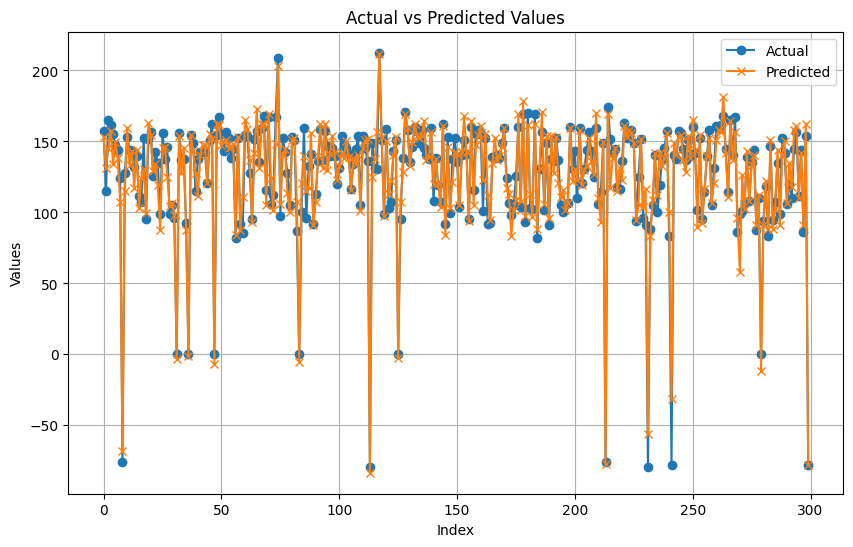

In [32]:
import matplotlib.pyplot as plt

# Sample data to simulate the user's `result_df` with 'Actual' and 'Predicted' columns
import pandas as pd
import numpy as np

# Creating a sample DataFrame to represent result_df with 'Actual' and 'Predicted' columns


# Plotting the 'Actual' and 'Predicted' values in a line graph
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Actual'], label='Actual', marker='o')
plt.plot(result_df.index, result_df['Predicted'], label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
